In [2]:
from time import time

import torch as th
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from FrEIA.framework import InputNode, OutputNode, Node, ReversibleGraphNet
from FrEIA.modules import GLOWCouplingBlock, PermuteRandom

import data

In [3]:
device = 'cuda' if th.cuda.is_available() else 'cpu'
print("Device: {}".format(device))

Device: cpu


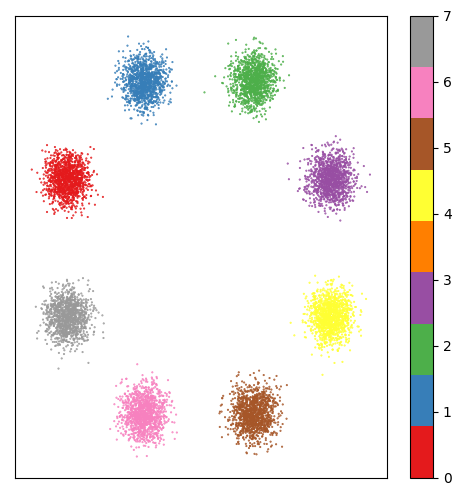

In [4]:
# Sample 제작
# label 은 cmap 에 해당하는 색 범위

batch_size = 1600
test_split = 10000

pos, labels = data.generate(
    labels='all',
    tot_dataset_size=2**20
)
c = np.where(labels[:test_split])[1]
plt.figure(figsize=(6, 6))
plt.scatter(pos[:test_split, 0], pos[:test_split, 1], c=c, cmap='Set1', s=0.25)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

In [6]:
ndim_tot = 16   # padding 을 통해 모든 차원을 16D 로 맞춘다.
ndim_x = 2      # 2차원 gaussian distribution          
ndim_y = 8      # 8D gaussian distribution
ndim_z = 2      # latent vector (x의 특징을 갖는다.)

# c_in 의 경우 ndim_tot의 절반이 된다.
# 아마 그래서 ndim_y 의 2배로 ndim_tot를 설정한 것 같다.
def subnet_fc(c_in, c_out):
    return nn.Sequential(
        nn.Linear(c_in, 512),
        nn.ReLU(),
        nn.Linear(512, c_out),
    )

nodes = [InputNode(ndim_tot, name='input')]

for k in range(8):
    nodes.append(Node(
        nodes[-1],
        GLOWCouplingBlock,
        {'subnet_constructor': subnet_fc, 'clamp':2.0},
        name=F'coupling_{k}'
    ))
    nodes.append(Node(
        nodes[-1],
        PermuteRandom,
        {'seed':k},
        name=F'permute_{k}'
    ))
nodes.append(OutputNode(nodes[-1], name='output'))

model = ReversibleGraphNet(nodes, verbose=True)


TypeError: __init__() got an unexpected keyword argument 'jac'

In [6]:
n_epochs = 100
n_its_per_epoch = 8

lr = 1e-3
l2_reg = 2e-5

y_noise_scale = 1e-1
zeros_noise_scale = 5e-2

lambd_predict = 3.
lambd_latent = 300.
lambd_rev = 400.

pad_x = th.zeros(batch_size, ndim_tot-ndim_x)
pad_yz = th.zeros(batch_size, ndim_tot-ndim_y-ndim_z)

"""
tranable parameter dimension (Network parameters)
[512, 8]
[512]
[16, 512]
...
[16, 512]
[16]
"""
trainable_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = th.optim.Adam(
    trainable_parameters,
    lr=lr,
    betas=(0.8, 0.9),
    eps=1e-6,
    weight_decay=l2_reg,
    )

# Maximum Mean Discrepancy(MMD) Loss, (Lz, p(y)p(z) 독립)
def MMD_multiscale(x, y):
    xx, yy, zz = th.mm(x, x.t()), th.mm(y,y.t()), th.mm(x, y.t())
    
    """
    unsqueeze: 괄호를 씌운다.
    unsqueeze(0): ([2]) -> ([1,2])
    unsqueeze(1): ([2]) -> ([2,1])

    expand_as(): 괄호 내 행렬과 똑같은 싸이즈로 기존 벡터/행렬을 확장한다.
    """
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2.*xx
    dyy = ry.t() + ry - 2.*yy
    dxy = rx.t() + ry - 2.*zz

    XX, YY, XY = (
        th.zeros(xx.shape).to(device),
        th.zeros(xx.shape).to(device),
        th.zeros(xx.shape).to(device),
    )

    for a in [0.05, 0.2, 0.9]:
        XX += a**2 * (a**2 + dxx)**-1
        YY += a**2 * (a**2 + dyy)**-1
        XY += a**2 * (a**2 + dxy)**-1

    return th.mean(XX + YY - 2.*XY)

# Mean Square Error (MSE), Ly(f(x),y)
def fit(input, target):
    return th.mean((input - target)**2)

# backward = { [y,z] -> x }
loss_backward = MMD_multiscale
loss_latent = MMD_multiscale

# fit = forward = { x -> [y,z] }
loss_fit = fit

test_loader = th.utils.data.DataLoader(
    th.utils.data.TensorDataset(pos[:test_split], labels[:test_split]),
    batch_size=batch_size, shuffle=True, drop_last=True,
)
train_loader = th.utils.data.DataLoader(
    th.utils.data.TensorDataset(pos[test_split:], labels[test_split:]),
    batch_size=batch_size, shuffle=True, drop_last=True,
)
"""
TensorDataset(x,y) or list(zip(x,y)) : 데이터를 튜플 형태로 만들어준다.
e.g. 
x = [[x11,x12],[x21, x22], [x31, x32]]
y = [y1, y2, y3]

return [([x11, x12], y1), ([x21, x22], y2), ([x31, x32], y3)]
"""

'\nTensorDataset(x,y) or list(zip(x,y)) : 데이터를 튜플 형태로 만들어준다.\ne.g. \nx = [[x11,x12],[x21, x22], [x31, x32]]\ny = [y1, y2, y3]\n\nreturn [([x11, x12], y1), ([x21, x22], y2), ([x31, x32], y3)]\n'

In [7]:
def train(i_epoch=0):
    model.train()

    l_tot = 0
    batch_idx = 0

    t_start = time()

    loss_factor = min(1., 2. * 0.002**(1. - (float(i_epoch) / n_epochs)))

    for x,y in train_loader:
        batch_idx += 1
        if batch_idx > n_its_per_epoch:
            break
        x, y = x.to(device), y.to(device)

        y_clean = y.clone()
        pad_x = zeros_noise_scale * th.randn(batch_size, ndim_tot - ndim_x, device=device)
        pad_yz = zeros_noise_scale * th.randn(batch_size, ndim_tot - ndim_y- ndim_z, device=device)

        y += y_noise_scale * th.randn(batch_size, ndim_y, dtype=th.float, device=device)
        
        # y 는 batch_size x 16, 2(z) + 6(pad) + 8(y)
        x, y = (
            th.cat((x, pad_x), dim=1),
            th.cat((th.randn(batch_size, ndim_z, device=device), pad_yz,y), dim=1)
        )

        optimizer.zero_grad()
        
        # Forward step:
        # Foward Net에 random x(?) 를 넣는다.
        output = model(x)[0]
        # pad 부분 빼고 y를 만든다.
        y_short = th.cat((y[:, :ndim_z], y[:,-ndim_y:]), dim=1)  
        # 지도학습 오차 계산
        l = lambd_predict * loss_fit(output[:, ndim_z:], y[:, ndim_z:])

        output_block_grad = th.cat((
            output[:, :ndim_z],
            output[:, -ndim_y:].data
        ), dim=1)
        
        # true data (y_short) 와 비지도학습 loss 계산
        l += lambd_latent * loss_latent(output_block_grad, y_short)
        l_tot += l.data.item()

        l.backward()

        # Backward step:
        # padding 생성
        pad_yz = zeros_noise_scale * th.randn(batch_size, ndim_tot-ndim_y-ndim_z, device=device)
        # noise 를 첨가한 y 생성
        y = y_clean + y_noise_scale * th.randn(batch_size, ndim_y, device=device)
        # Foward 결과중 z 에 노이즈 추가
        orig_z_pertubed = (output.data[:, :ndim_z] + y_noise_scale * th.randn(batch_size, ndim_z, device=device))
        # 노이즈 추가된 z 와 padding, y  값 결합
        y_rev = th.cat((orig_z_pertubed, pad_yz, y), dim=1)
        # random z 값과 padding, y 값 결합.
        y_rev_rand = th.cat((th.randn(batch_size, ndim_z, device=device), pad_yz, y), dim=1)
        # Forward 의 결과인 z 를 다시 inverse 함
        output_rev = model(y_rev, rev=True)[0]
        # z 를 random 값을 사용해 inverse 함
        output_rev_rand = model(y_rev_rand, rev=True)[0]

        # 비지도학습 오차 ? 
        l_rev = (
            lambd_rev * loss_factor * loss_backward(output_rev_rand[:, :ndim_x],
            x[:, :ndim_x])
        )
        # 뭔오차 ?
        l_rev += lambd_predict * loss_fit(output_rev, x)

        l_tot += l_rev.data.item()
        l_rev.backward()

        # for p in model.parameters(): 
        #     p.grad.data.clamp_(-15.00, 15.00)
        
        optimizer.step()

    return l_tot / batch_idx

100%|#########################################| 100/100 [03:36<00:00,  2.17s/it]



Training took 3.62 minutes



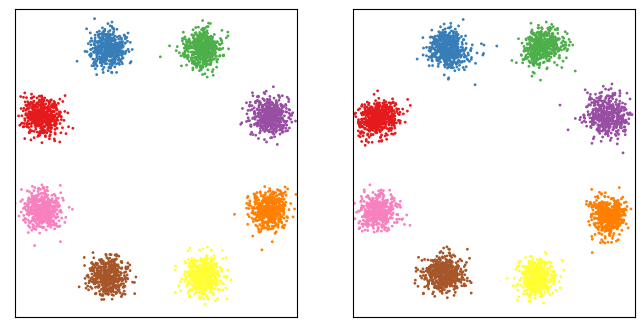

In [8]:
for param in trainable_parameters:
    param.data = 0.05 * th.randn_like(param)

model.to(device)

fig, axes = plt.subplots(1,2, figsize=(8,4))
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('Predicted lables (Forwards Process)')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Generated Samples (Backwards Process)')
# fig.show()
fig.canvas.draw()

N_samp = 4096

x_samps = th.cat([x for x,y in test_loader], dim=0)[:N_samp]
y_samps = th.cat([y for x,y in test_loader], dim=0)[:N_samp]
c = np.where(y_samps)[1]
y_samps += y_noise_scale * th.randn(N_samp, ndim_y)
y_samps = th.cat([th.randn(N_samp, ndim_z),
                     zeros_noise_scale * th.zeros(N_samp, ndim_tot - ndim_y - ndim_z), 
                     y_samps], dim=1)
y_samps = y_samps.to(device)

try:
    t_start = time()
    for i_epoch in tqdm(range(n_epochs), ascii=True, ncols=80):
        train(i_epoch)

        rev_x = model(y_samps, rev=True)[0]
        rev_x = rev_x.cpu().data.numpy()

        pred_c = model(th.cat((x_samps, th.zeros(N_samp, ndim_tot-ndim_x)),
        dim=1).to(device))[0].data[:, -8:].argmax(dim=1)
        axes[0].clear()
        axes[0].scatter(x_samps.cpu()[:,0], x_samps.cpu()[:,1], c=pred_c.cpu(), cmap='Set1', s=1., vmin=0, vmax=9)
        axes[0].axis('equal')
        axes[0].axis([-3,3,-3,3])
        axes[0].set_xticks([])
        axes[0].set_yticks([])

        axes[1].clear()
        axes[1].scatter(rev_x[:,0], rev_x[:,1], c=c, cmap='Set1', s=1., vmin=0, vmax=9)
        axes[1].axis('equal')
        axes[1].axis([-3,3,-3,3])
        axes[1].set_xticks([])
        axes[1].set_yticks([])
        
        fig.canvas.draw()
        

except KeyboardInterrupt:
    pass
finally:
    print(f"\n\nTraining took {(time()-t_start)/60:.2f} minutes\n")
